In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import pathlib

2025-10-15 17:19:05.206645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_dir = pathlib.Path('data/train/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28709


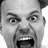

In [ ]:
angry = list(data_dir.glob('angry/*'))
disgust = list(data_dir.glob('disgust/*'))
fear = list(data_dir.glob('fear/*'))
happy = list(data_dir.glob('happy/*'))
neutral = list(data_dir.glob('neutral/*'))
sad = list(data_dir.glob('sad/*'))
surprise = list(data_dir.glob('surprise/*'))

PIL.Image.open(str(angry[0]))
# PIL.Image.open(str(fear[0]))

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1760563159.619832    3274 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [ ]:
# Normalization is made in the layers - This code is therefore useless
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.0 0.9862875


In [ ]:
# Important - Set weights as the dataset is imbalanced
from sklearn.utils import class_weight

train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_labels),
    y = train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("Class Weight Dictionary:", class_weight_dict)

In [ ]:
# # Ancient code for training from scratch - complete sequential without any transfer learning
# num_classes = len(train_ds.class_names)

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

In [ ]:
# ImageNet needs input in three channels, because it was trained on RGB images. This is why we convert the grayscale images to RGB by repeating the single channel three times.
# Even if the images are already grayscaled in the dataset, this conversion ensures that there is three channels with the same values to prevent any noise.
def convert_grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

# Convert the whole dataset


In [ ]:
# Optimization for performance
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
num_classes = len(train_ds.class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)



In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3,
  class_weight=class_weight_dict
)

Epoch 1/3


2025-10-15 17:19:40.434870: I external/local_xla/xla/service/service.cc:163] XLA service 0x75695c0054c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-15 17:19:40.434931: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-10-15 17:19:40.491022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-15 17:19:40.765006: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-15 17:19:40.814454: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-15 17:19:42.813158: I e

  7/718 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1630 - loss: 1.9549

I0000 00:00:1760563187.646212    3725 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


715/718 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2982 - loss: 1.7318

2025-10-15 17:20:02.771303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_555', 8 bytes spill stores, 8 bytes spill loads



718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.3483 - loss: 1.6450 - val_accuracy: 0.4092 - val_loss: 1.5116
Epoch 2/3
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.4664 - loss: 1.3857 - val_accuracy: 0.4747 - val_loss: 1.3708
Epoch 3/3
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5491 - loss: 1.1910 - val_accuracy: 0.4867 - val_loss: 1.3706


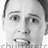

In [37]:
sample_img_path = fear[20]
PIL.Image.open(str(sample_img_path))

In [38]:

img = tf.keras.utils.load_img(str(sample_img_path), target_size=(img_width, img_height))
# img_array = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # add batch dimension

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_index = np.argmax(score)
predicted_class_name = train_ds.class_names[predicted_index]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class_name, 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This image most likely belongs to fear with a 81.92 percent confidence.
